# Showcase

In [1]:
library(here)
source(here("setup.R"))
options(encoding = "UTF-8")
Sys.setlocale("LC_ALL", "C")


here() starts at /Users/stefan/workspace/work/phd/thesis



[1] "C/C/C/C/C/de_DE"

In [2]:
full_truth_county <- read_csv(here("data/processed/RKI_county_weekly.csv")) 

full_truth <- full_truth_county %>%
    group_by(date) %>%
    summarize(cases = sum(cases, na.rm = TRUE))

ags_county_dict <- read_csv(here("data/processed/ags_county_dict.csv")) %>%
    mutate(c = 1:n())

In [3]:
showcase_results <- read_csv(here("data/results/4_local_outbreak_model/showcase.csv"))

In [4]:
y_total_result <- showcase_results %>% 
    filter(variable == "y_total") 

In [5]:
rename_pct_to_decimal <- function(x) as.numeric(gsub("%", "", x)) / 100

y_total_dist <- y_total_result %>% 
    select(ends_with('%')) %>%
    pivot_longer(cols = everything(), names_to = "percentile", values_to = "value") %>%
    mutate(percentile = rename_pct_to_decimal(percentile)) %>%
    bind_rows(tibble(value = c(0, Inf), percentile = c(0, 1))) %>%
    arrange(value)

## Comparison to NBinom baseline

In [6]:
prediction_date <- showcase_results %>% pull(date) %>% max
baseline_df <- full_truth %>%
    filter(date <= prediction_date - 7, date >= prediction_date - 14) 

growth_rate <- baseline_df %>%
    pull(cases) %>%
    log %>% diff %>% exp

lambda_old <- baseline_df %>%
    pull(cases) %>%
    tail(1)

lambda_new <- lambda_old * growth_rate

In [7]:
baseline_county <- full_truth_county %>% filter(date <= prediction_date - 7, date >= prediction_date - 14)
I_old_county <- baseline_county %>%
    group_by(ags) %>%
    summarize(cases = cases[2]) 

emp_rho_c <- baseline_county %>%
    group_by(ags) %>%
    summarize(growth_rate = exp(diff(log(cases)))) 
rho_c_cleaned <- emp_rho_c %>%
    mutate(growth_rate = ifelse(is.na(growth_rate) | is.infinite(growth_rate), 1.0, growth_rate)) %>%
    mutate(growth_rate = pmin(growth_rate, 3))

lambda_new_county <-  rho_c_cleaned %>%
    inner_join(I_old_county) %>%
    mutate(intensity_prediction = growth_rate * cases) %>%
    pull(intensity_prediction) 

Joining with `by = join_by(ags)`


In [8]:
total_nb_obs <- full_truth %>%
    filter(date >= ymd('2020-04-25'), date<= prediction_date - 7) %>%
    mutate(rho = cases / lag(cases)) %>%
    mutate(predicted = lag(cases) * lag(rho)) %>%
    tail(-2) %>%
    dplyr::select(y = cases, mu = predicted)

est_r <- function(df) {
    loglik <- function(r) -sum(dnbinom(df$y, mu = df$mu, size = r))
    r_est <- optimize(loglik, interval=c(1e-3,1e3))$minimum
}

nb_quantiles <- qnbinom(y_total_dist$percentile, mu = lambda_new, size = est_r(total_nb_obs)) %>%
    tibble(
        percentile = y_total_dist$percentile,
        value = .
    ) %>%
    pivot_wider(names_from = percentile, values_from = value) %>%
    mutate(date = prediction_date)
nb_quantiles

0,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,⋯,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99,1,date
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
0,5250,5426,5581,5763,5888,5988,6076,6155,6228,⋯,6726,6810,6905,7017,7159,7373,7562,7786,Inf,2020-06-27


In [126]:
N_samples <- 1e5
total_county_nb_obs <- full_truth_county %>%
    filter(date >= ymd('2020-04-25'), date<= prediction_date - 7) %>%
    group_by(ags) %>%
    mutate(rho = cases / lag(pmax(cases, 1))) %>%
    mutate(predicted = pmax(lag(cases) * lag(rho), 1)) %>%
    ungroup() %>%
    filter(!is.na(predicted)) %>%
    dplyr::select(ags, y = cases, mu = predicted)

county_rs <- total_county_nb_obs %>%
    group_by(ags) %>%
    summarize(r = est_r(cur_data())) %>%
    mutate(mu = lambda_new_county)

nbinom_county_samples <- rnbinom(N_samples * 400, mu = county_rs$mu, size = county_rs$r) %>%
    matrix(c(400, N_samples)) 

nb_county_quantiles <-  nbinom_county_samples %>%
    colSums %>%
    quantile(probs = y_total_dist$percentile) %>%
    tibble(
        percentile = y_total_dist$percentile,
        value = .
    ) %>%
    pivot_wider(names_from = percentile, values_from = value) %>%
    mutate(date = prediction_date)

## `tikz/regional_showcase_predictions.tex`

pdf 
  2

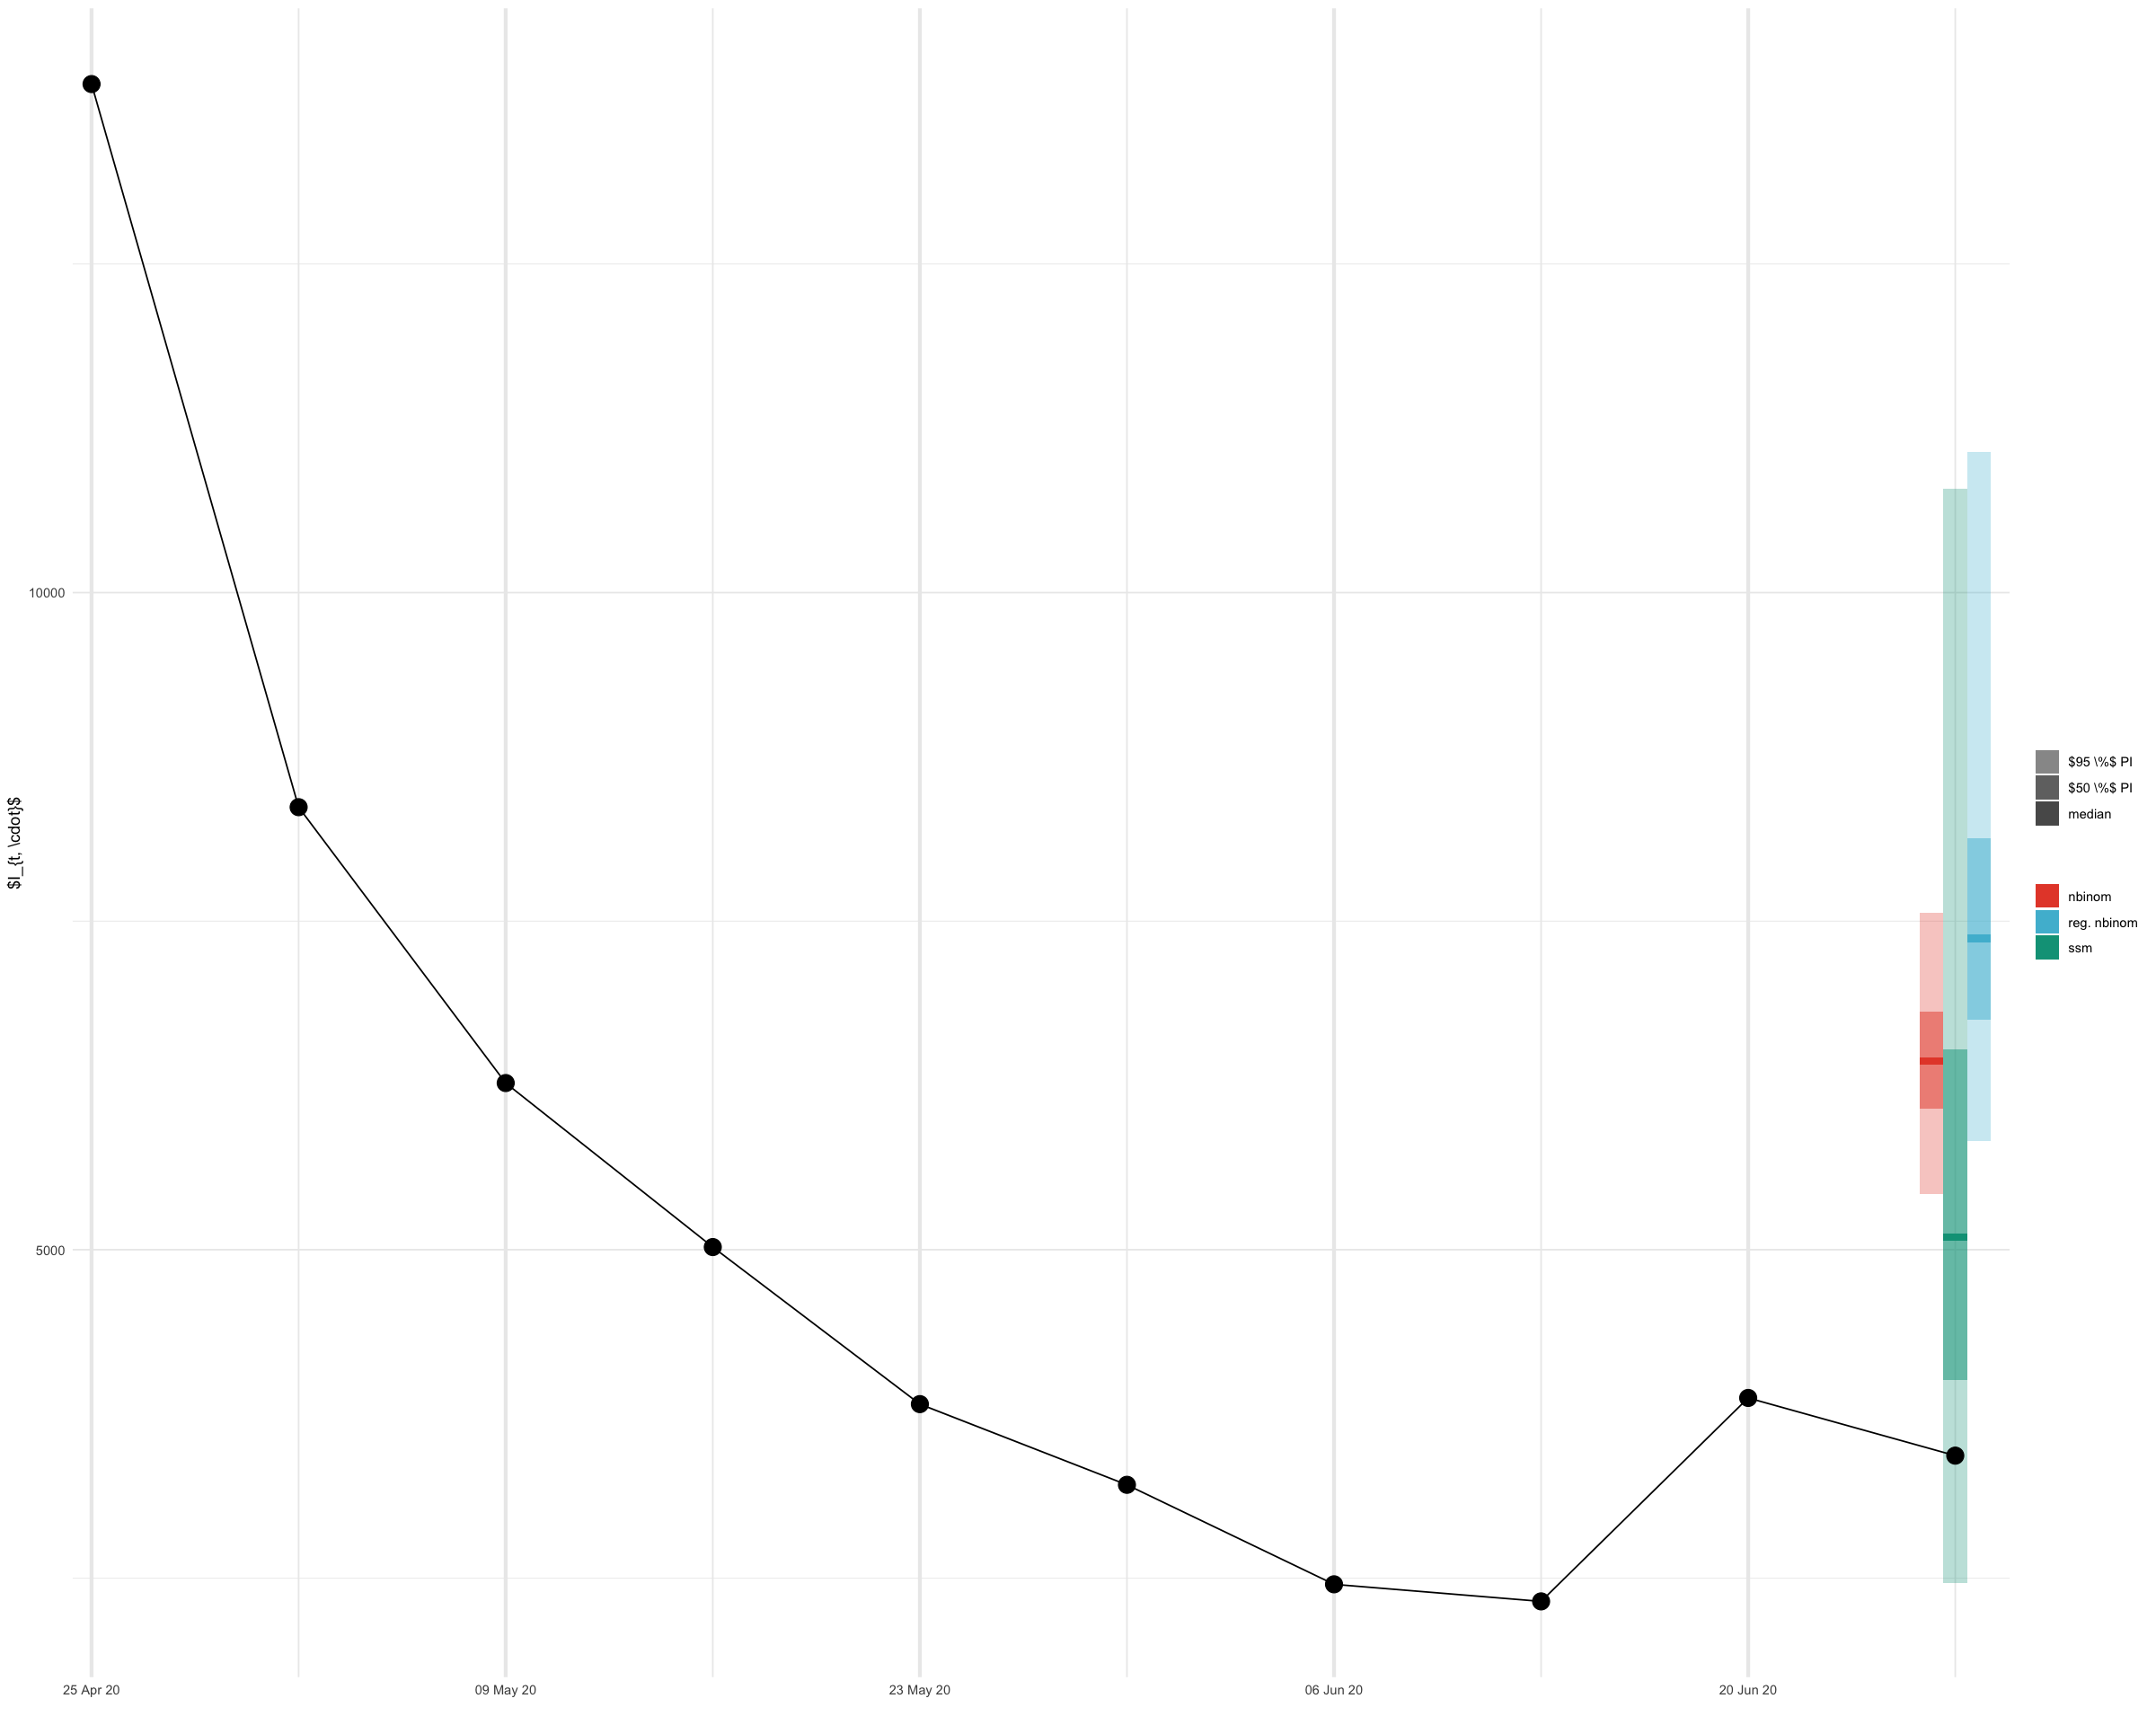

In [140]:
dx <- .4

alpha_fct <- factor(c("median", "$50 \\%$ PI", "$95 \\%$ PI"), levels=c("median", "$50 \\%$ PI", "$95 \\%$ PI"))
col = pal_npg("nrc")(10)[3]


geom_prediction_interval <- function(model, data, dx=1, offset=0) {
    list(
        geom_rect(aes(xmin = date - dx + offset, xmax= date+dx + offset, ymin = `0.025`, ymax = `0.975`, alpha=alpha_fct[3], fill=model), data=data),
        geom_rect(aes(xmin = date - dx + offset, xmax= date+dx + offset, ymin = `0.25`, ymax = `0.75`, alpha=alpha_fct[2], fill=model), data=data),
        geom_rect(aes(xmin= date - dx + offset, xmax=date + dx + offset, ymin = `0.5`-30, ymax=`0.5`+30, alpha=alpha_fct[1], fill=model), data=data)
    )
}

y_result_plot <- y_total_result %>%
    rename_with(function(x) as.character(rename_pct_to_decimal(x)), ends_with('%')) 

full_truth %>%
    inner_join(y_result_plot, by=c("date"="date")) %>%
    ggplot(aes()) +
    geom_prediction_interval("ssm", data=y_result_plot, dx=dx) +
    geom_prediction_interval("nbinom", data=nb_quantiles, dx=dx,offset=-2*dx) +
    geom_prediction_interval("reg. nbinom", data=nb_county_quantiles, dx=dx, offset=2*dx) +

    geom_line(aes(date, cases), data= full_truth %>% filter(date >= ymd('2020-04-25'), date <= ymd('2020-06-27'))) +
    geom_point(aes(date, cases), data= full_truth %>% filter(date >= ymd('2020-04-25'), date <= ymd('2020-06-27')), size=5)  +
    scale_alpha_manual(name="", values=c("median"=1, "$50 \\%$ PI"=0.5, "$95 \\%$ PI"=0.3)) +
    labs(x="", y="$I_{t, \\cdot}$", fill="") +
    scale_x_date(
        breaks = function(x) seq(ceiling_date(x[1], "week", week_start = 6), floor_date(x[2], "week", week_start = 6), by = "2 week"),
        date_labels = "%d %b %y",
        expand = expansion(mult = c(0.01, 0.01))
    ) +
    theme(
        panel.grid.major.x = element_line(linewidth = 1.2),
        panel.grid.minor.x = element_line(linewidth = 0.5)
    ) +
    scale_fill_npg()

ggsave_tikz(here("tikz/regional_showcase_prediction.tex"), width=16/1.5, height=7/1.5)


## `tables/regional_showcase_theta.tex`

In [11]:
parameters <- read_csv(here("data/results/4_local_outbreak_model/estimated_parameters.csv"), col_names = c("parameter", "value")) %>% 
    pivot_wider(names_from = parameter, values_from = value) %>%
    rename(
        "$\\alpha$" = alpha,
        "$\\sigma_{\\overline{\\log \\rho}}$" = sigma_r,
        "$\\sigma_{S}$" = "sigma spatial",
        "$\\bar{q}$" = q,
        "$C$" = C,
        "$r$" = r
    ) %>%
    pivot_longer(everything(), names_to="parameter", values_to="estimate")

parameters %>%
    kable(format = "latex", digits=3, booktabs=T, escape=F) %>%
    cat(., file=here("tables/regional_showcase_theta.tex"))


Warning message:
"Removed 335 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 400 rows containing missing values or values outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 166 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 335 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 400 rows containing missing values or values outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 166 rows containing missing values or values outside the scale range
(`geom_line()`)."


pdf 
  2

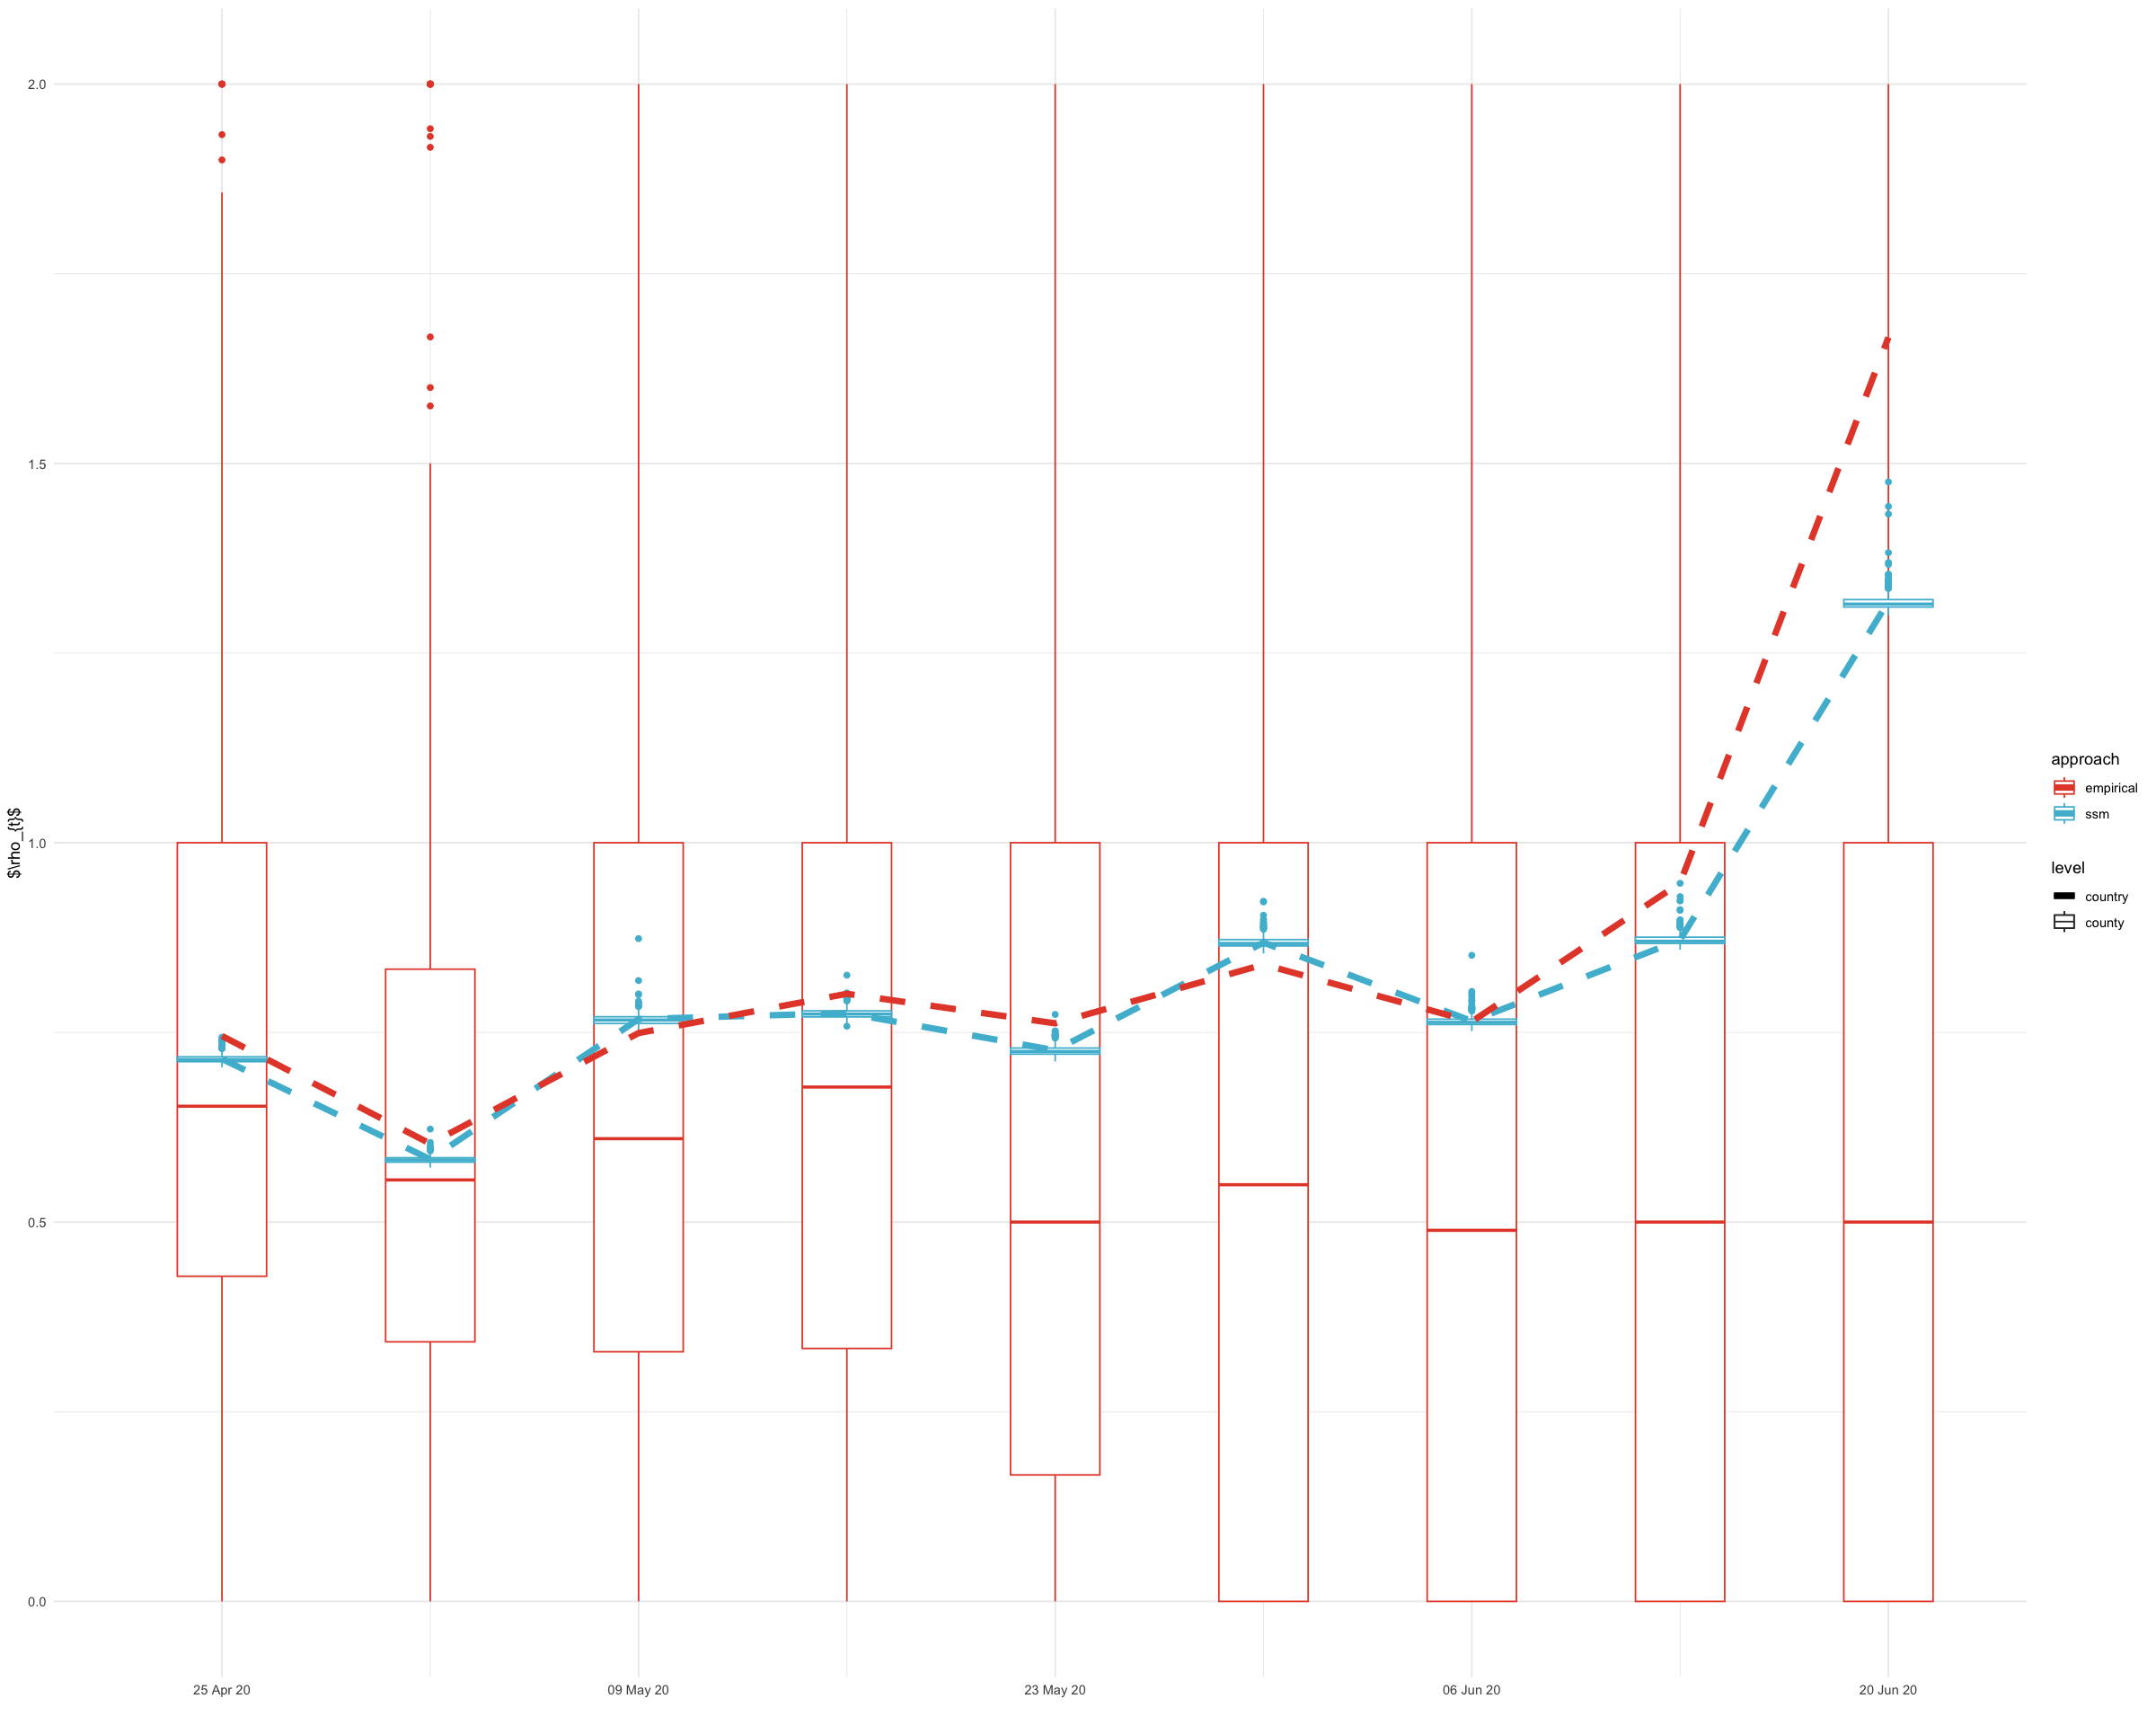

In [139]:
approaches <- factor(c("ssm", "empirical"), levels = c("ssm", "empirical"))

ssm_app <- approaches[1]
empirical_app <- approaches[2]

emp_rho_plt <- full_truth_county %>%
    filter(date >= ymd('2020-04-18'), date<= prediction_date - 7) %>%
    group_by(ags) %>% 
    mutate(rho = cases / lag(pmax(cases, 1))) %>%
    filter(!is.na(rho)) 

showcase_results %>%
    filter(variable == "log_rho") %>%
    ggplot(aes(date, exp(`50.0 %`), color=ssm_app)) +
    geom_boxplot(aes(date, rho, color=empirical_app, group = date, linetype='county'), data = emp_rho_plt, width=3) +
    geom_boxplot(aes(group = date, color=ssm_app, linetype='county'), data = log_rhos, width=3) +
    geom_line(aes(linetype='country'), linewidth=2) +
    geom_line(data = full_truth %>% mutate(rho = cases / lag(cases)), aes(date, rho, color=empirical_app, linetype='country'), linewidth=2) +
    ylim(0,2) +
    scale_x_date(
        breaks = function(x) seq(ceiling_date(x[1], "week", week_start = 6), floor_date(x[2], "week", week_start = 6), by = "2 week"),
        date_labels = "%d %b %y",
        expand = expansion(mult = c(0.01, 0.01)),
        limits = c(ymd('2020-04-20'), ymd('2020-06-24'))
    ) +
    labs(color="approach", linetype='level', x="", y="$\\rho_{t}$") +
    scale_linetype_manual(values = c('county'='solid', 'country'='dashed')) 

ggsave_tikz(here("tikz/regional_showcase_rho.tex"), width=16/1.5, height=7/1.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


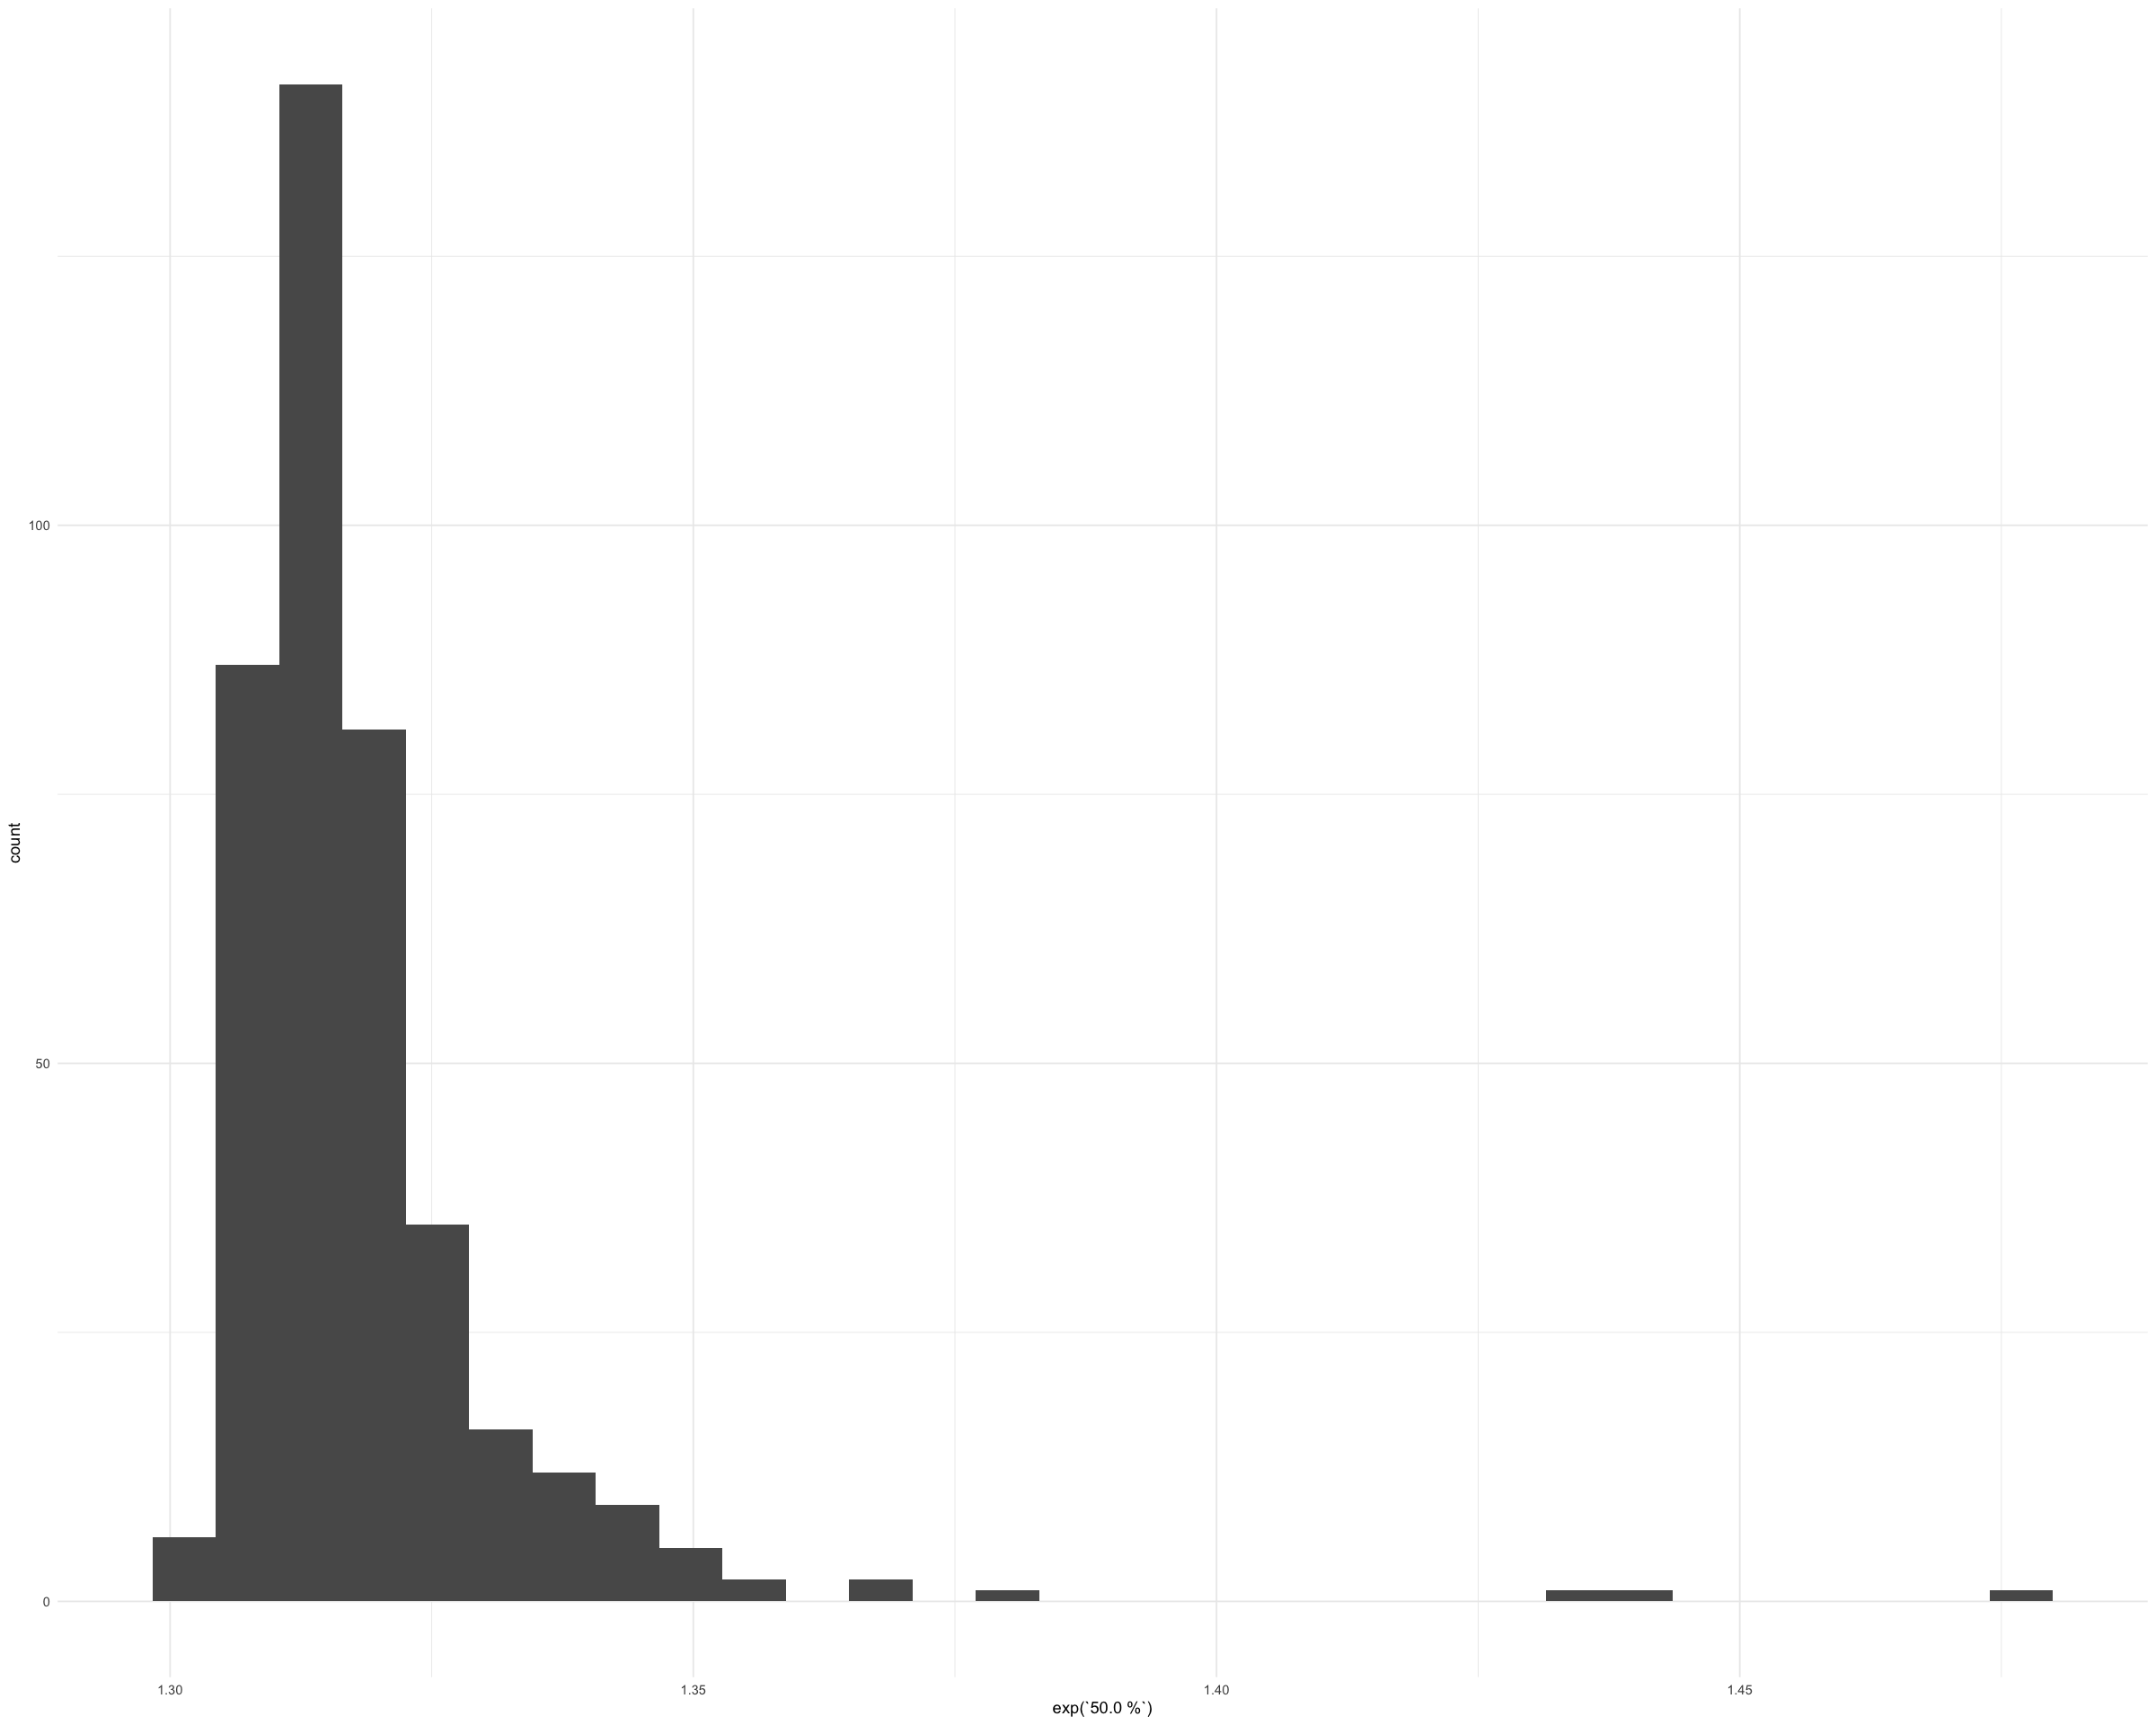

In [34]:
log_rhos %>% 
    filter(date == prediction_date - 7) %>%
    ggplot(aes(exp(`50.0 %`))) +
    geom_histogram()

variable,c,t,mean,sd,1.0 %,2.5 %,5.0 %,10.0 %,15.0 %,⋯,65.0 %,70.0 %,75.0 %,80.0 %,85.0 %,90.0 %,95.0 %,97.5 %,99.0 %,date
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
log_rho_1_1,1,1,-0.3441763,0.08285410,-0.5378148,-0.5092936,-0.4817860,-0.4525260,-0.4300845,⋯,-0.3141724,-0.3024136,-0.2900315,-0.2756754,-0.2567394,-0.2354801,-0.2054213,-0.1807626,-0.1515435,2020-04-25
log_rho_2_1,2,1,-0.3340966,0.08298063,-0.5210205,-0.4964027,-0.4692382,-0.4413380,-0.4193641,⋯,-0.3038564,-0.2907455,-0.2788289,-0.2648047,-0.2463578,-0.2269759,-0.1975185,-0.1697339,-0.1395154,2020-04-25
log_rho_3_1,3,1,-0.3467728,0.08675607,-0.5587506,-0.5154396,-0.4870722,-0.4578671,-0.4372137,⋯,-0.3152791,-0.3026187,-0.2886219,-0.2732954,-0.2578267,-0.2359374,-0.2065007,-0.1768622,-0.1264585,2020-04-25
log_rho_4_1,4,1,-0.3312374,0.08605359,-0.5193349,-0.4962975,-0.4751558,-0.4442055,-0.4232115,⋯,-0.2964753,-0.2837992,-0.2704300,-0.2556998,-0.2395206,-0.2196040,-0.1884740,-0.1683474,-0.1432149,2020-04-25
log_rho_5_1,5,1,-0.3415284,0.08661346,-0.5410972,-0.5121812,-0.4859810,-0.4515556,-0.4310055,⋯,-0.3089250,-0.2972819,-0.2849853,-0.2693135,-0.2525795,-0.2298929,-0.1975233,-0.1719569,-0.1432151,2020-04-25
log_rho_6_1,6,1,-0.3396096,0.07415273,-0.5062983,-0.4833034,-0.4631190,-0.4346935,-0.4182776,⋯,-0.3118320,-0.3003653,-0.2883826,-0.2757534,-0.2614137,-0.2442879,-0.2165234,-0.1937042,-0.1720287,2020-04-25


Warning message:
"Removed 400 rows containing missing values or values outside the scale range
(`geom_line()`)."


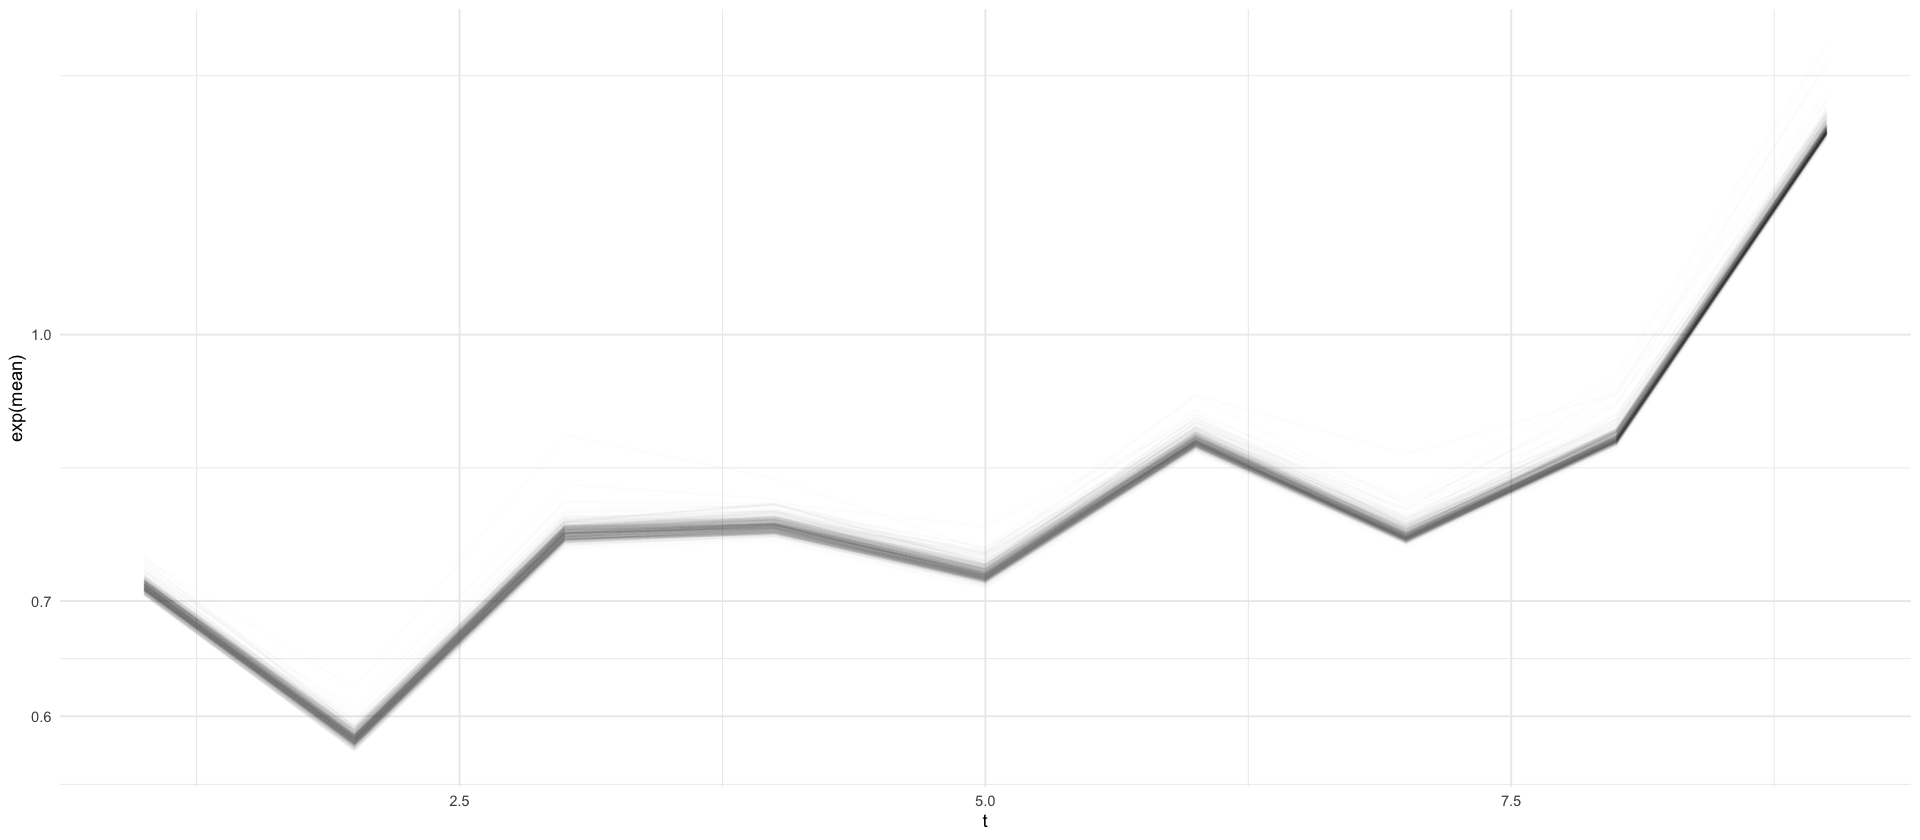

In [13]:
log_rhos <- showcase_results %>%
    filter(str_starts(variable, "log_rho_")) %>%
    # extract both indices from variable names like log_rho_2_1
    mutate(c = as.numeric(str_extract(variable, "log_rho_(\\d+)_(\\d+)", group=1))) %>%
    mutate(t = as.numeric(str_extract(variable, "log_rho_(\\d+)_(\\d+)", group=2))) 
log_rhos %>%
    head()

log_rhos %>%
    mutate(c = factor(c)) %>%
    ggplot(aes(t, exp(mean), group=c)) +
    geom_line(show.legend=FALSE, alpha=1/100) +
    xlim(NA, 9) +
    scale_y_log10()

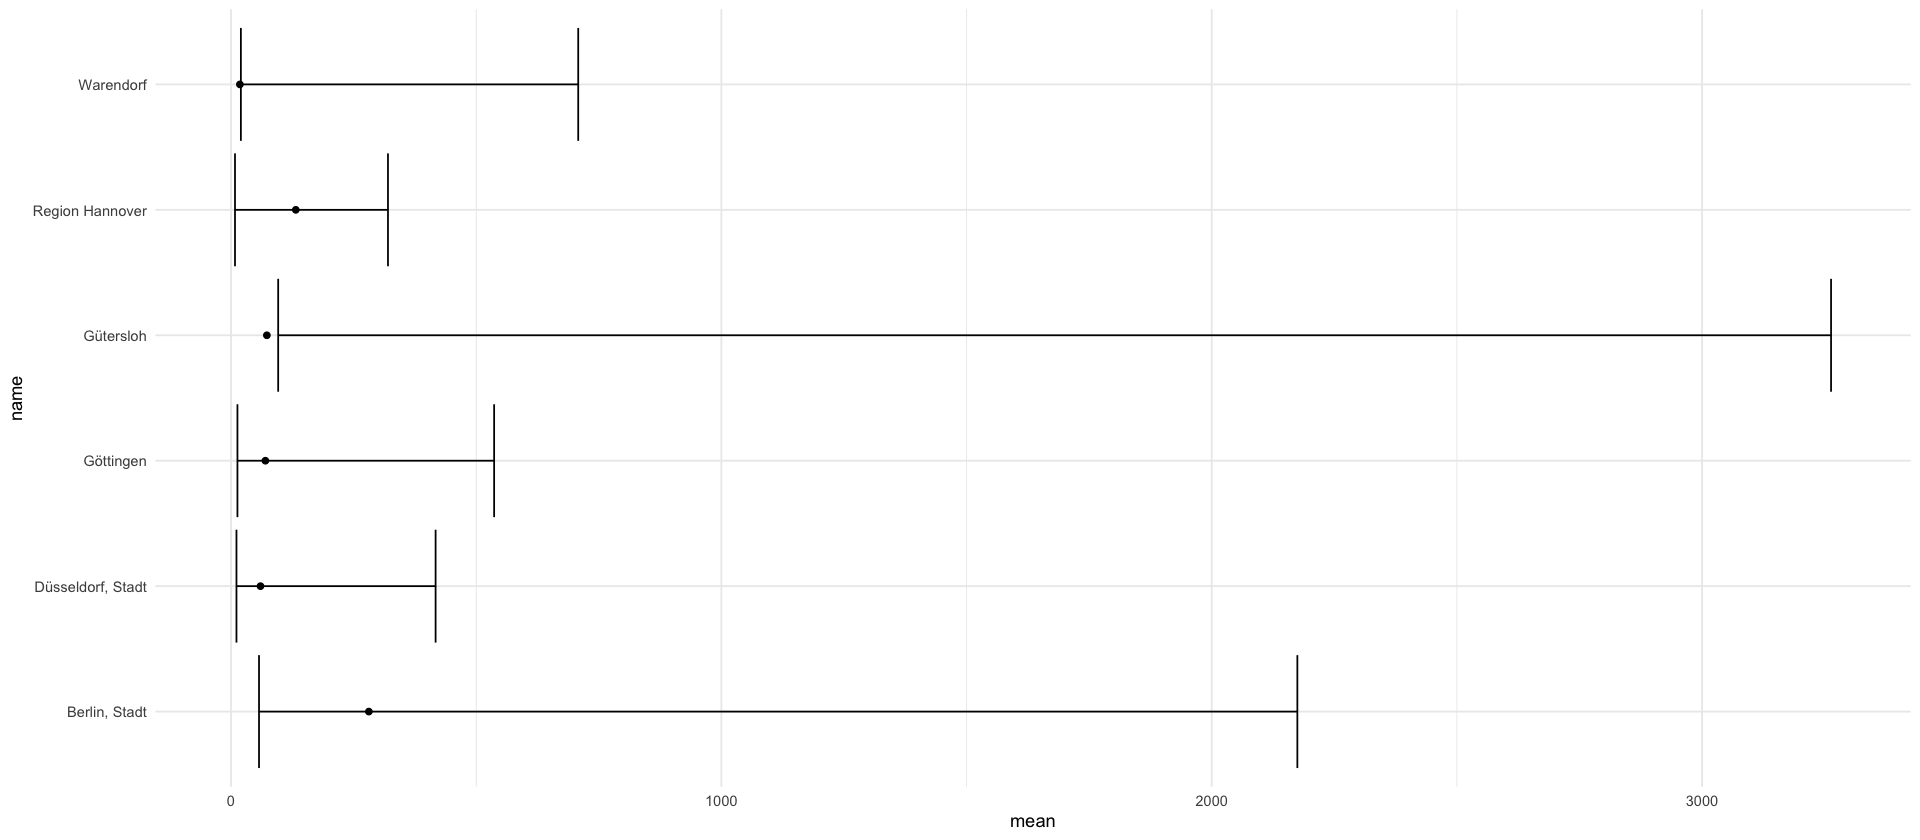

In [14]:
showcase_results %>%
    filter(str_starts(variable, "y_total_")) %>%
    mutate(c = as.numeric(str_extract(variable, "y_total_(\\d+)", group=1))) %>%
    inner_join(ags_county_dict, by = "c") %>%
    inner_join(filter(full_truth_county, date == '2020-06-13'), by=c("ags")) %>%
    filter(mean >= 100) %>%
    arrange(desc(mean)) %>%
    ggplot(aes(y = name, x = mean)) +
    geom_errorbarh(aes(xmin = `2.5 %`, xmax = `97.5 %`)) +
    geom_point(aes(x = cases))

## Exchange matrix P

In [15]:
ags_county_dict <- read_csv(here("data/processed/ags_county_dict.csv"))
ags_state_dict <- read_csv(here("data/processed/ags_state_dict.csv"))

index_to_state <- ags_county_dict %>% 
    mutate(i = 1:400) %>%
    mutate(state_ags = str_sub(ags, end=2)) %>%
    rename(county_name = name) %>%
    inner_join(ags_state_dict, by=c("state_ags"="ags"))  %>%
    select(i, state_ags, county_name, state_name = name)

pdf 
  2

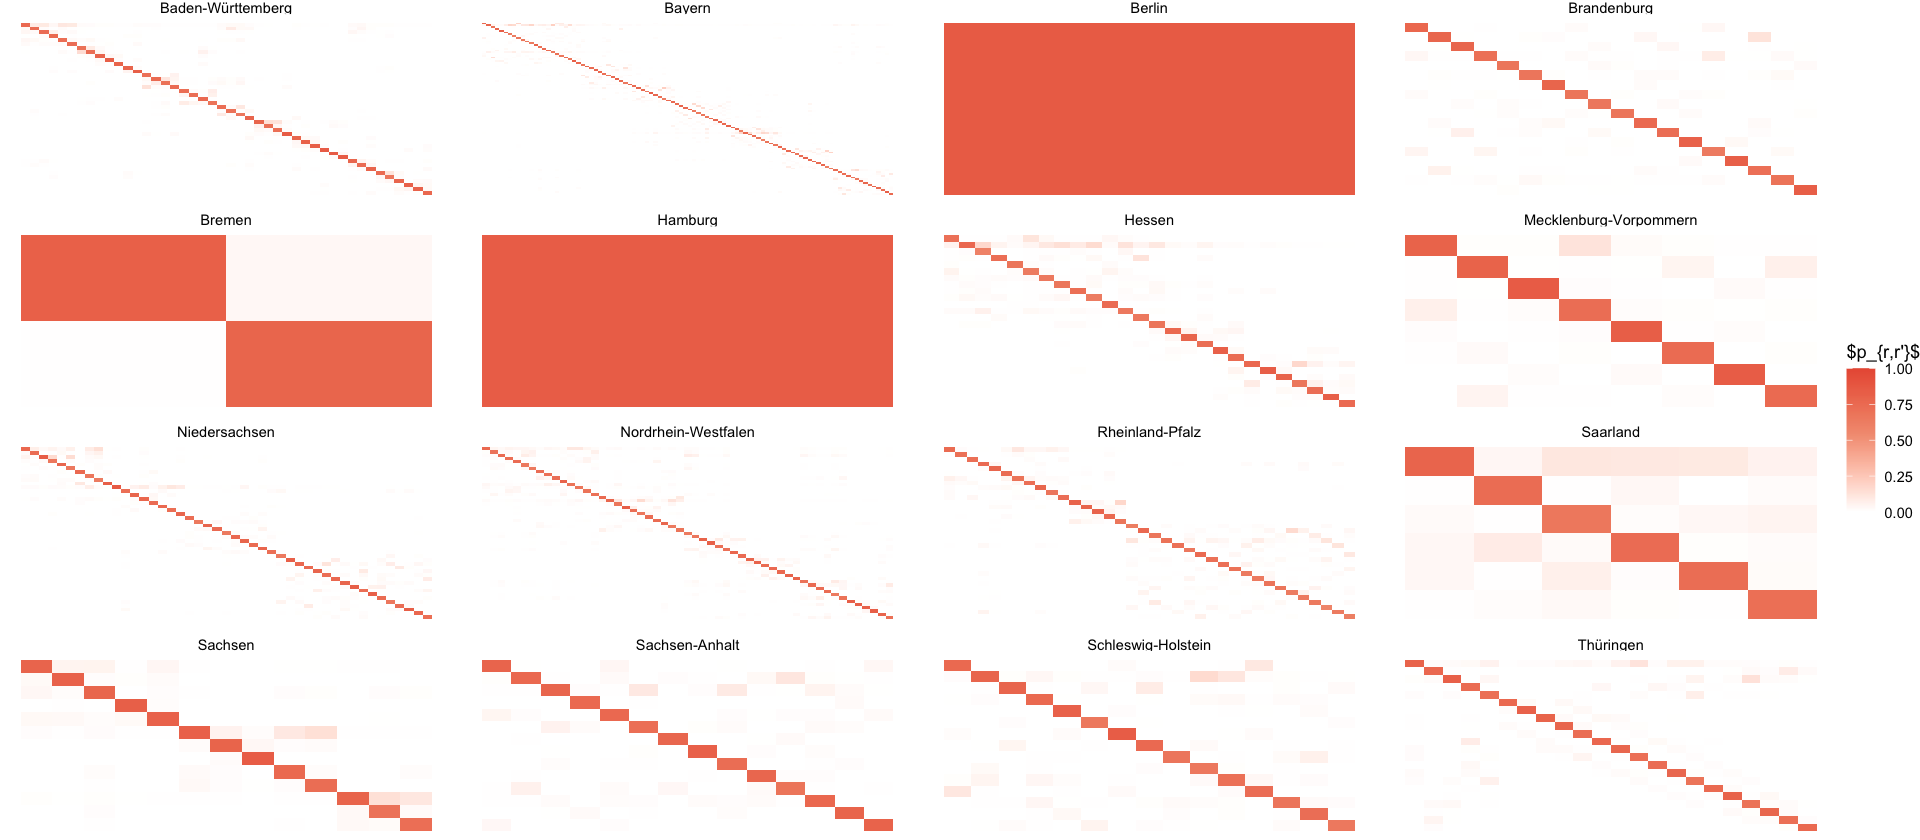

In [16]:
P <- read_delim(here("data/results/4_local_outbreak_model/showcase_P_matrix.csv"), delim = " ", col_names = 1:400) %>%
    as.matrix()


colnames(P) <- NULL
P_long_states <- melt(P) %>%
    rename(i = Var1, j = Var2) %>%
    inner_join(select(index_to_state, i, state_name_i = state_name), by=c("i")) %>%
    inner_join(select(index_to_state, j=i, state_name_j = state_name), by=c("j")) 
    
P_long_states %>%
    filter(state_name_i == state_name_j) %>%
    ggplot(aes(i,-j, fill=value)) +
    geom_tile() +
    scale_fill_gradient2(
        low = "white",
        mid = pal_npg("nrc")(5)[5],
        high = pal_npg("nrc")(5)[1],
        midpoint = 0.55,  # Set midpoint where you want emphasis
        limits = c(0,1)
    ) +
    facet_wrap(~state_name_i, scales="free") +
    theme_void() +
    labs(fill= "$p_{r,r'}$")


ggsave_tikz(here("tikz/P_matrix.tex"))

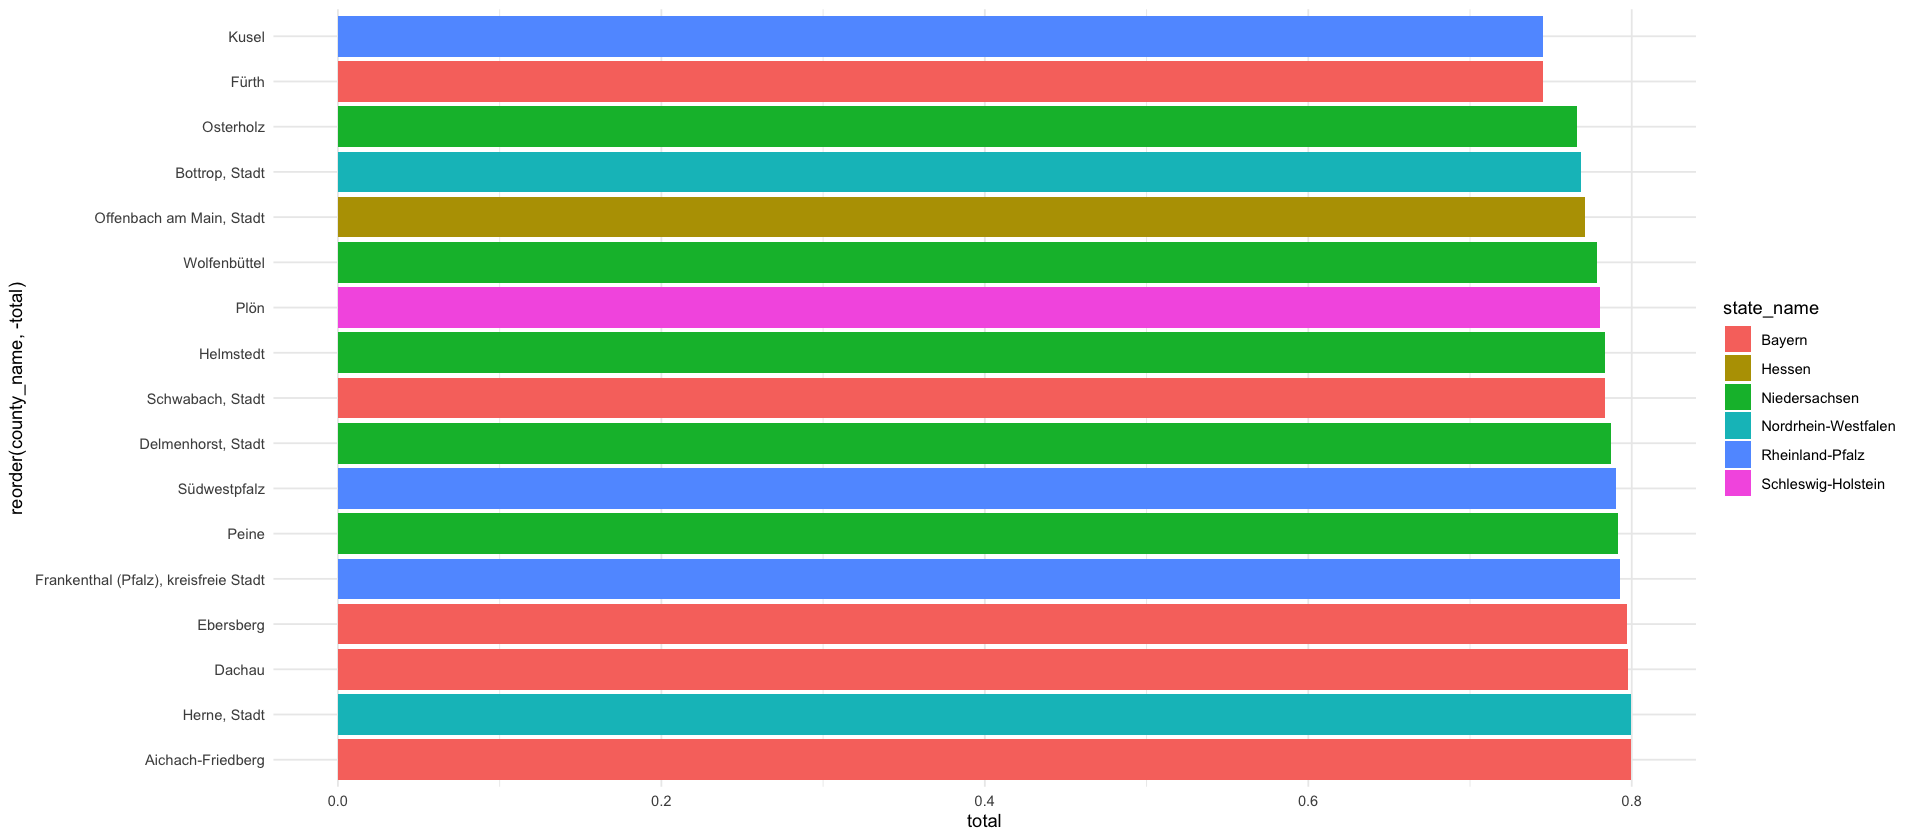

In [17]:
tibble(
    total = colSums(P),
    i = 1:400,
    p_ii = diag(P)
) %>%
    inner_join(index_to_state, by=c("i")) %>%
    filter(total < 0.8) %>%
    ggplot(aes(x = reorder(county_name, -total), y = total, fill=state_name)) +
    geom_bar(stat = "identity") +
    coord_flip()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


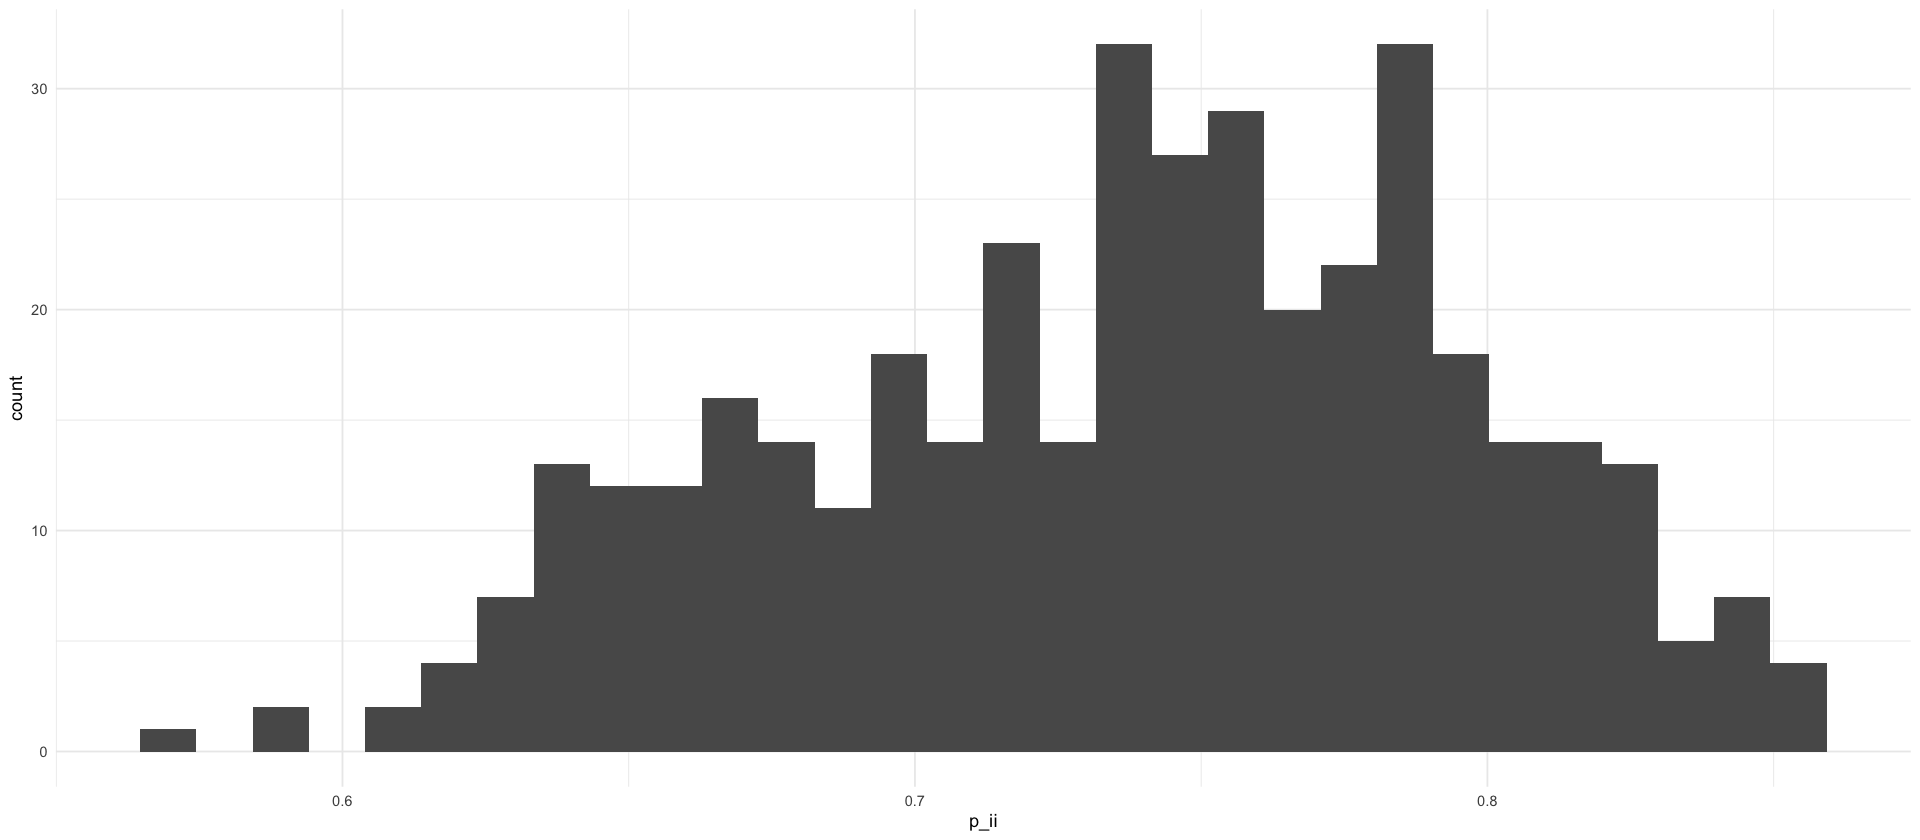

In [18]:
tibble(
    p_ii = diag(P),
    i = 1:400
) %>%
    inner_join(index_to_state, by=c("i")) %>%
    ggplot(aes(x = p_ii)) +
    geom_histogram()

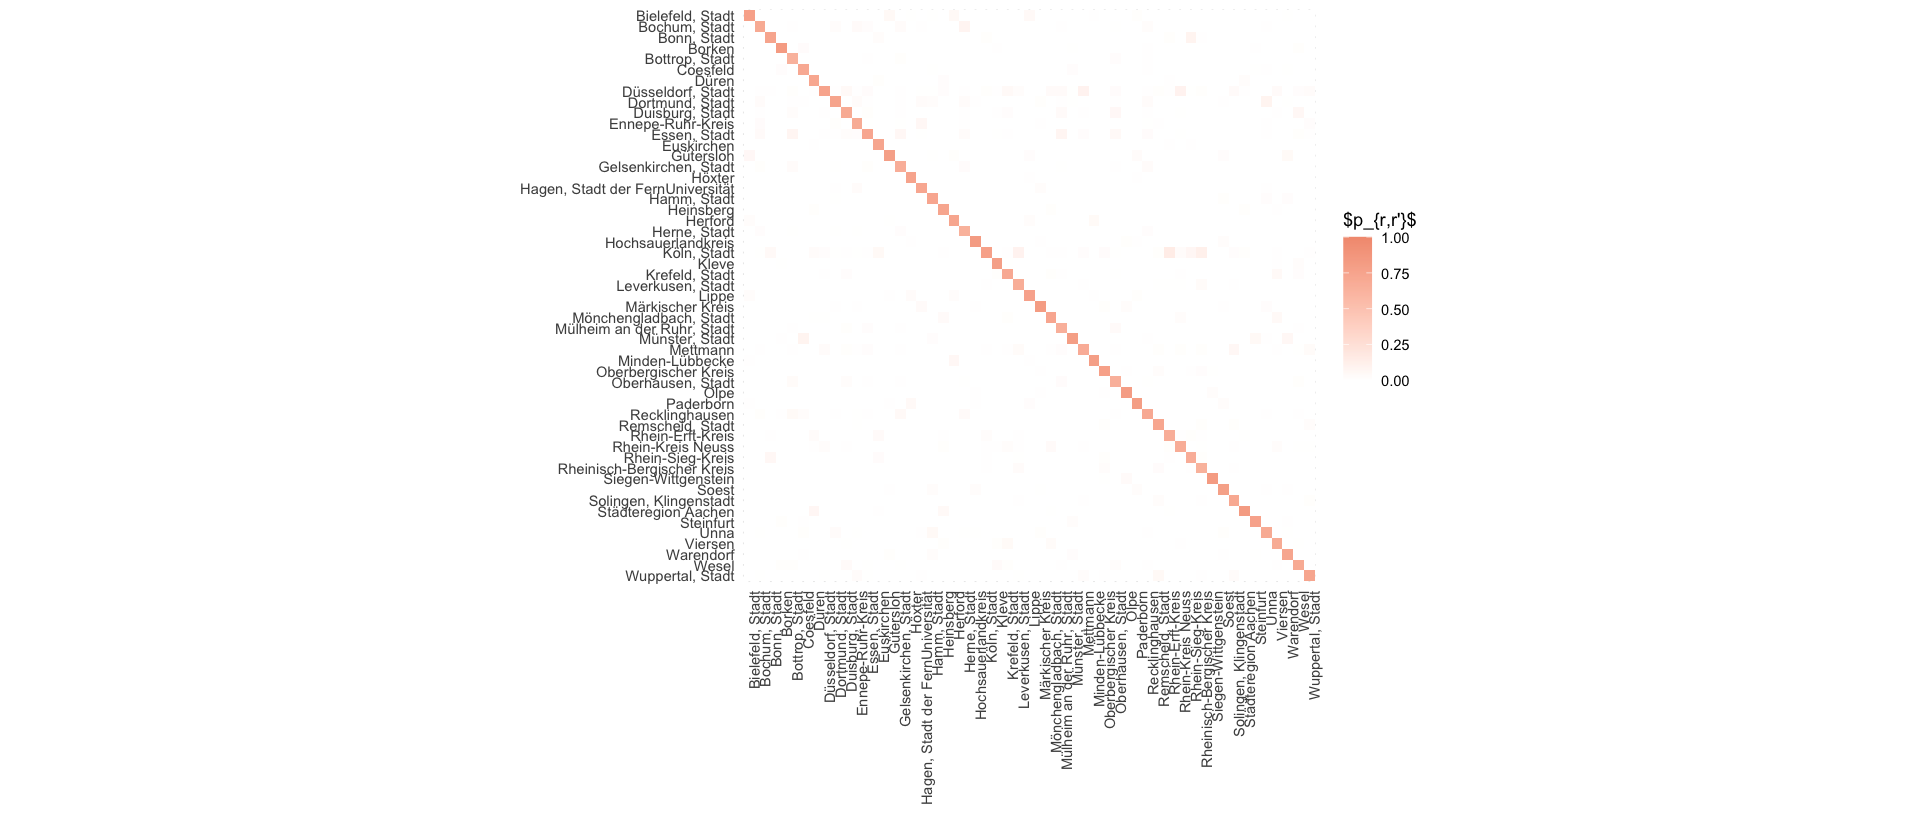

In [19]:
nrw_ags <- ags_state_dict %>%
    filter(name == "Nordrhein-Westfalen") %>%
    pull(ags)

nrw_counties <- ags_county_dict %>%
    mutate(i = 1:400) %>%
    filter(str_starts(ags, nrw_ags)) %>%
    rename(county_name = name) %>%
    select(i, county_name)
    

P_nrw <- melt(P) %>%
    rename(i = Var1, j = Var2) %>%
    inner_join(select(nrw_counties, i, county_name_i = county_name), by=c("i")) %>%
    inner_join(select(nrw_counties, j=i, county_name_j = county_name), by=c("j"))  %>%
    filter()

P_nrw %>%
    ggplot(aes(county_name_i,county_name_j, fill=value)) +
    geom_tile() +
    scale_fill_gradient(
        low = "white",
        high = pal_npg("nrc")(5)[5],
        limits = c(0,1)
    ) +
    scale_y_discrete(limits=rev) +
    theme_minimal() +
    labs(fill= "$p_{r,r'}$", x="", y="") +
    theme(
        axis.text.x = element_text(angle=90, hjust=1)
    ) +
    coord_fixed()

# Comparison to ECDC forecasts

In [20]:
forecasts_directory <- here("data/results/4_local_outbreak_model")

df_forecasts <- list.files(forecasts_directory, pattern="forecasts_.*.csv", full.names = TRUE)  %>%
    # infer the forecast date from the filename - have to add 10 weeks to the date in the filename as it is the initial date
    lapply(function(file) read_csv(file) %>% mutate(date = ymd(str_extract(string = file, pattern = "\\d{4}-\\d{2}-\\d{2}")) + days(10 * 7))) %>% 
    bind_rows(.)

In [21]:
df_baseline <- read_csv(here("data/processed/ECDC_FCH_EuroCOVIDhub-baseline.csv")) %>%
    filter(date <= max(df_forecasts$date))

df_itww <- read_csv(here("data/processed/ECDC_FCH_ITWW-county_repro.csv")) %>%
    filter(date <= max(df_forecasts$date))

df_ensemble <- read_csv(here("data/processed/ECDC_FCH_EuroCOVIDhub-ensemble.csv")) %>%
    filter(date <= max(df_forecasts$date))


In [22]:
all_df <- rbind(
    df_forecasts %>% filter(variable == 'y_total') %>% select(df_baseline %>% names) %>% mutate(model='ssm'),
    df_baseline %>% mutate(model='baseline'),
    df_itww %>% mutate(model='itww'),
    df_ensemble %>% mutate(model='ensemble')
)

## `tikz/regional_forecasts_comparison.tex`

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."


pdf 
  2

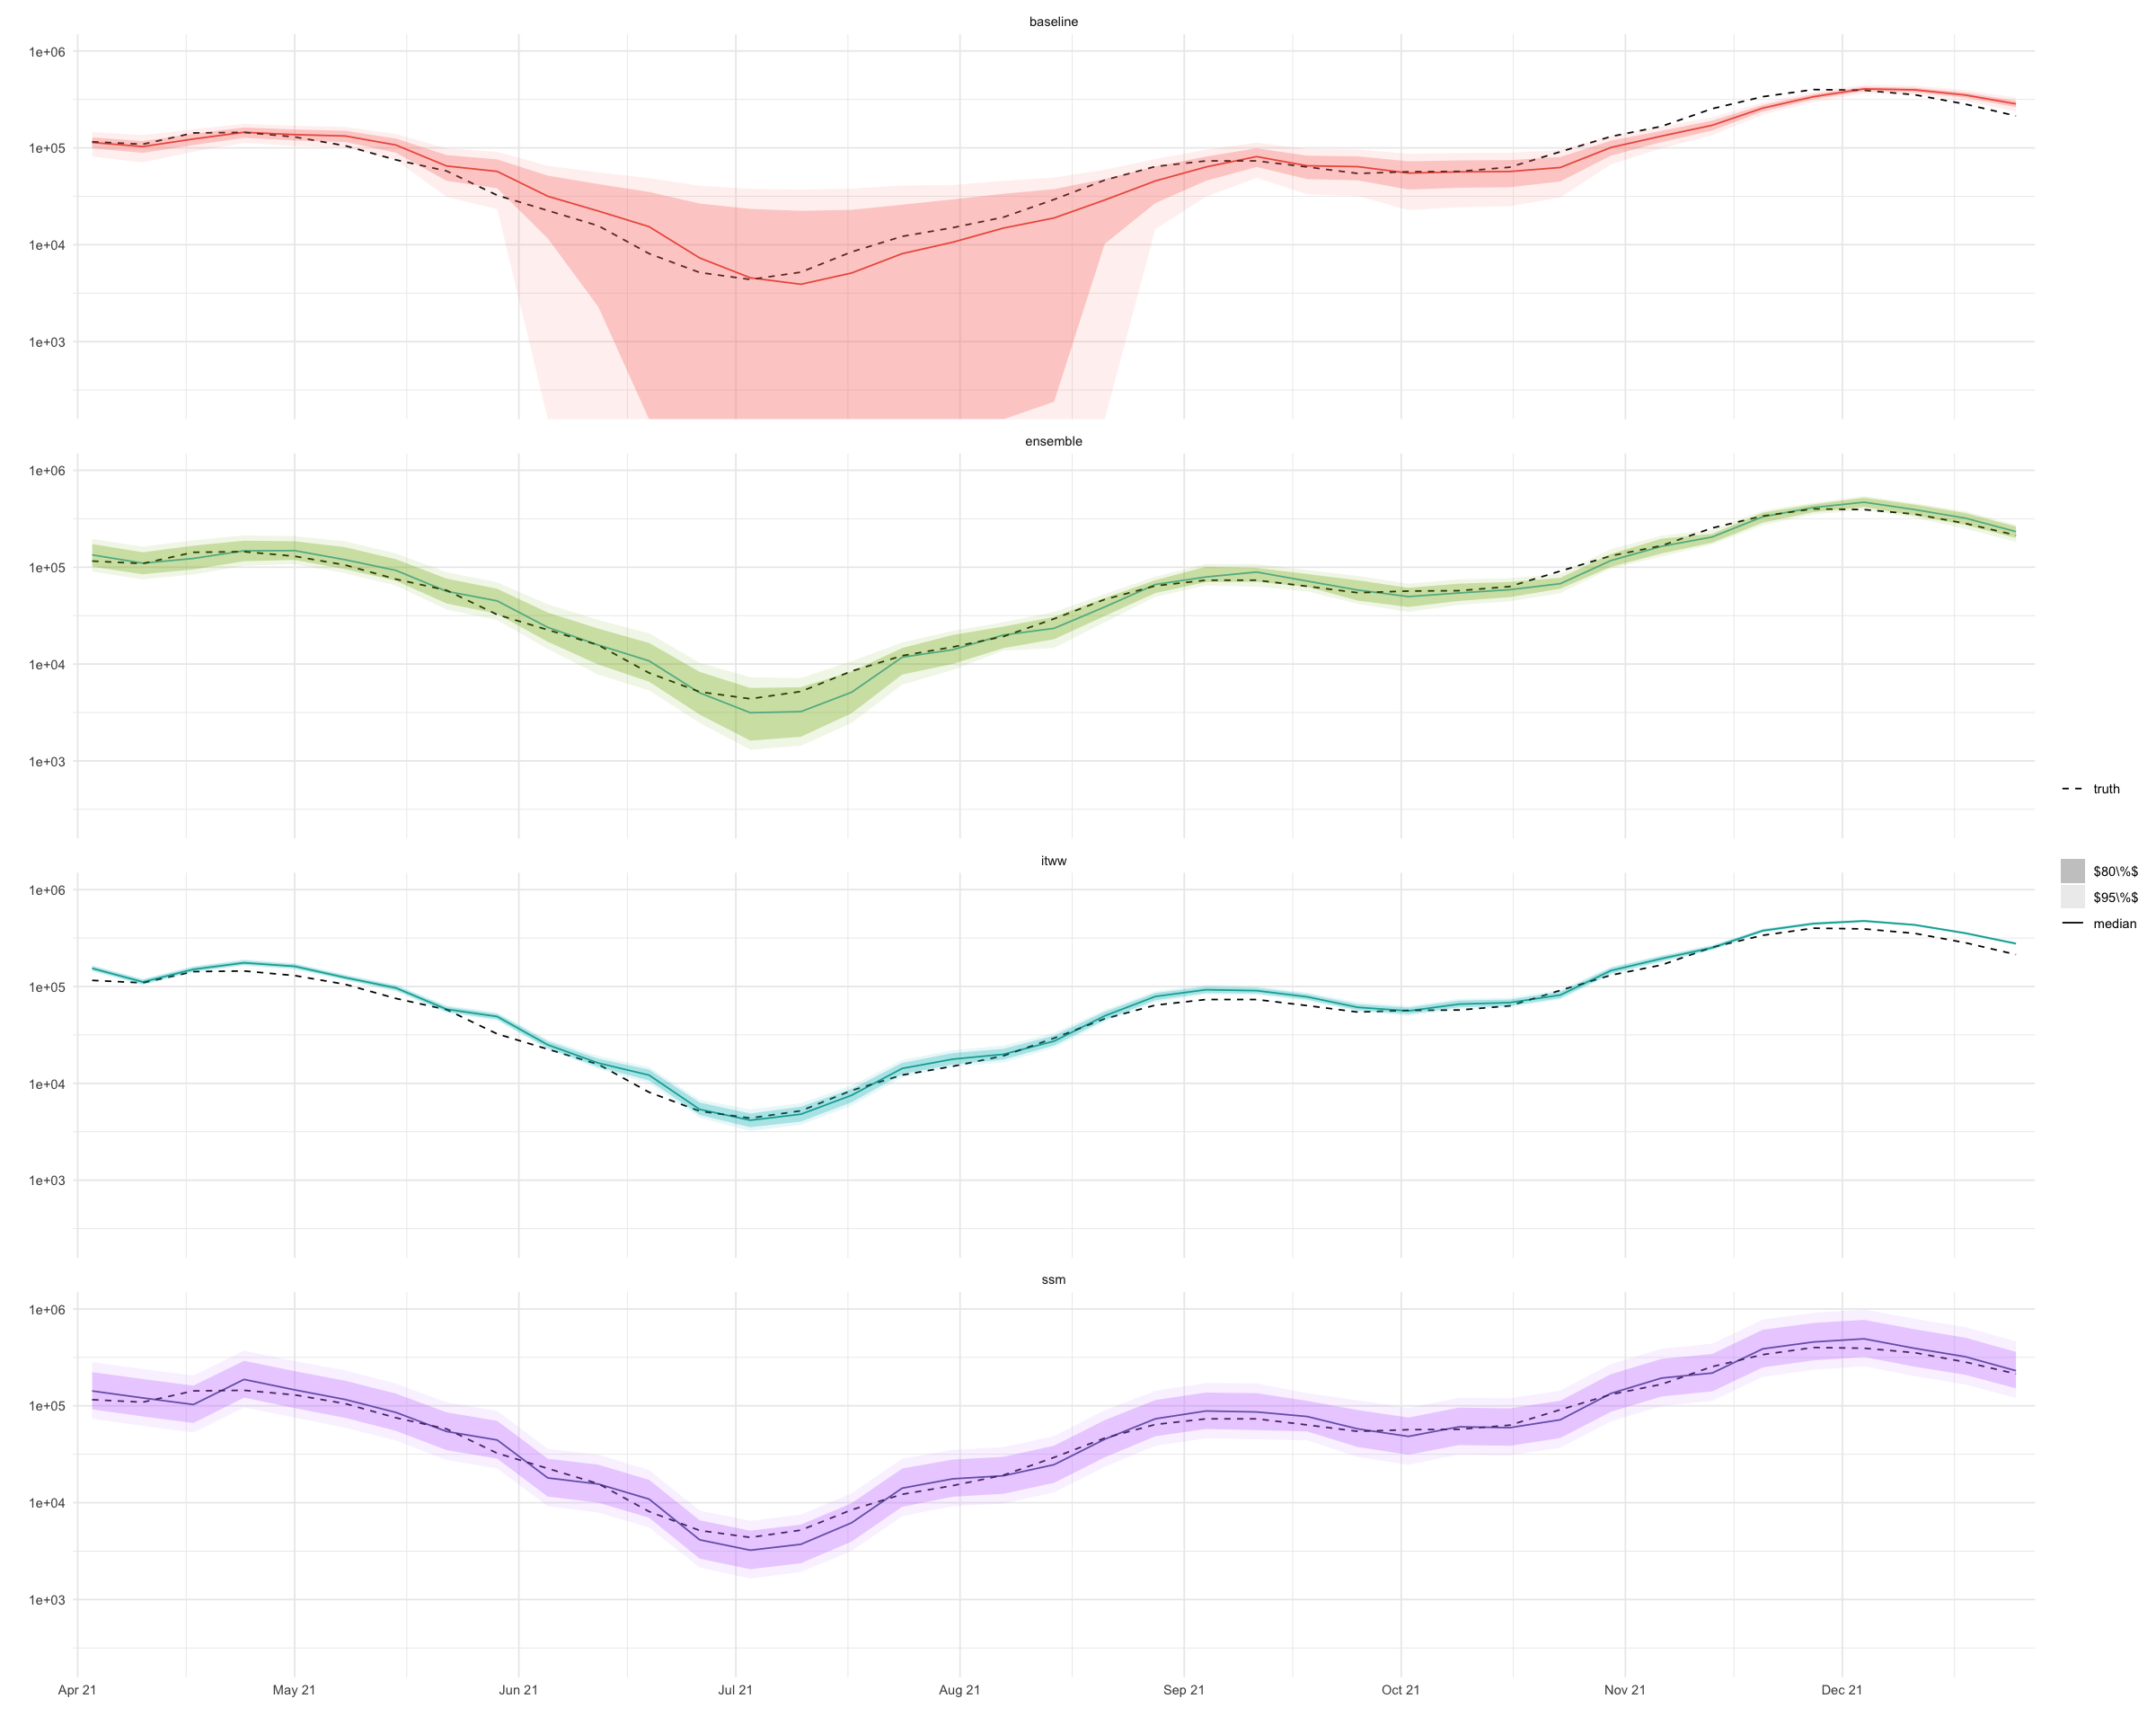

In [23]:
# larger figures
options(
    repr.plot.width=20,
    repr.plot.height=16
)
ggplot(all_df, aes(date)) +
    geom_line(aes(y=`50.0 %`, color=model, alpha="median")) +
    geom_line(aes(x = date, y = cases, linetype = "truth"), data = filter(full_truth, date <= max(all_df$date), date >= min(all_df$date))) +
    geom_ribbon(aes(ymin = `10.0 %`, ymax = `90.0 %`, fill = model, alpha="$80\\%$")) +
    geom_ribbon(aes(ymin = `2.5 %`, ymax = `97.5 %`, fill = model, alpha="$95\\%$")) +
    labs(x = "", y = "", linetype = NULL, fill = NULL, alpha="") +
    guides(fill="none", color="none") +
    scale_x_date(breaks = "1 months", date_labels = "%b %y", expand = expansion(mult = c(0.01, 0.01))) + 
    scale_linetype_manual(values=c("truth" = 2))+
    scale_alpha_manual(values = c("median" = 1, "$80\\%$" = 0.3, "$95\\%$" = 0.1)) +
    facet_wrap(~model, ncol = 1)  +
    scale_y_log10()

ggsave_tikz(
    here("tikz/regional_forecasts_comparison.tex"),
    width=16/1.5, height=12/1.5
)

## `tables/regional_forecasts_combined_performance.tex`

In [162]:
quantiles <- c(0.01, 0.025, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975, 0.99)
df <- full_truth %>% 
    inner_join(all_df, by="date") %>%
    rename(truth=cases) %>%
    rowwise() %>%
    mutate(
        WIS_decompose = list(WIS_decompose(
            prob=quantiles,
            quant=c(`1.0 %`, `2.5 %`, `5.0 %`, `10.0 %`, `15.0 %`, `20.0 %`, `25.0 %`, `30.0 %`, `35.0 %`, `40.0 %`, `45.0 %`, `50.0 %`, `55.0 %`, `60.0 %`, `65.0 %`, `70.0 %`, `75.0 %`, `80.0 %`, `85.0 %`, `90.0 %`, `95.0 %`, `97.5 %`, `99.0 %`),
            actual= truth
           ))
    ) %>%
    unnest_wider(WIS_decompose) %>%
    group_by(model) %>%
    summarize(
        mae = mean(abs(`50.0 %` - truth), na.rm = TRUE),
        WIS = mean(wis),
        sharpness = mean(sharpness),
        underprediction = mean(underprediction),
        overprediction = mean(overprediction),
        mean_error = mean(mean_error),
        length_95 = mean(`97.5 %` - `2.5 %`, na.rm = TRUE),
        length_50 = mean(`75.0 %` - `25.0 %`, na.rm = TRUE),
        coverage_50 = mean(`25.0 %` <= truth & truth <= `75.0 %`, na.rm = TRUE),
        coverage_95 = mean(`2.5 %` <= truth & truth <= `97.5 %`, na.rm = TRUE),
    ) 

df_table_performance <- df %>%
  mutate(coverage_50 = coverage_50 * 100) %>%
  mutate(coverage_95 = coverage_95 * 100) %>%
  rename(
    `Mean Absolute Error` = mae,
    `WIS` = WIS,
    `Sharpness` = sharpness,
    `Underprediction` = underprediction,
    `Overprediction` = overprediction,
    `Coverage 50% PI [%]` = coverage_50,
    `Coverage 95% PI [%]` = coverage_95,
  ) %>%
  select(-length_95, -length_50, -mean_error) %>%
  t() %>%  # Transpose
  as.data.frame() %>%  # Convert to data frame
  rownames_to_column(var = "metric") %>%
  setNames(c("metric", .[1,2:5])) %>%
  slice(-1)

In [163]:
df_table_performance

metric,baseline,ensemble,itww,ssm
<chr>,<chr>,<chr>,<chr>,<chr>
Mean Absolute Error,19664.56,11874.82,18227.64,16697.13
WIS,13907.185,6877.498,14486.062,9637.172
Sharpness,1462.8722,2742.6090,850.6181,7563.0616
Underprediction,7055.1655,1637.4615,141.1469,598.1981
Overprediction,4493.2704,1973.1142,12686.5361,865.9655
Coverage 50% PI [%],25.64103,43.58974,23.07692,74.35897
Coverage 95% PI [%],82.05128,94.87179,46.15385,100.00000


In [164]:
df_table_relative_performance <- df_table_performance %>%
    mutate(across(baseline:ssm, as.numeric)) %>%
    # relative to baseline, first column
    mutate(across(ensemble:ssm, ~ .x / baseline)) %>%
    select(-baseline) %>%
    filter(metric %in% c('Mean Absolute Error', 'WIS'))

In [165]:
# function that formats numbers for LaTeX
format_latex <- function(x) {
  x <- round(as.numeric(x), 2)
  x <- format(x, nsmall = 2, big.mark = ",", scientific = FALSE)
  return(x)
}


In [166]:
library(kableExtra)

# Add baseline column to relative metrics (filled with 1.000)
df_table_relative_performance$baseline <- 1.000

# Reorder columns to match the absolute table structure
df_table_relative_performance <- df_table_relative_performance[, c("metric", "baseline", "ensemble", "itww", "ssm")]

# Combine the datasets
combined_table <- rbind(df_table_performance, df_table_relative_performance)

# Create the combined table with section headers
combined_table %>%
    # round to two digits
    mutate(across(baseline:ssm, format_latex)) %>%
    # add thousands separator in latex
    kable(format="latex", digits=3, booktabs=T, escape=T, align = c("l", "r", "r", "r", "r")) %>%
    pack_rows("absolute performance", 1, nrow(df_table_performance) - 2) %>%
    pack_rows("coverage", nrow(df_table_performance) - 1, nrow(df_table_performance)) %>%
    pack_rows("relative to baseline", nrow(df_table_performance) + 1, nrow(combined_table)) %>%
    cat(., file=here("tables/regional_forecasts_combined_metrics.tex"))


In [53]:
full_truth %>% 
    inner_join(all_df, by="date") %>%
    rename(truth=cases) %>%
    rowwise() %>%
    mutate(
        WIS_decompose = list(WIS_decompose(
            prob=quantiles,
            quant=c(`1.0 %`, `2.5 %`, `5.0 %`, `10.0 %`, `15.0 %`, `20.0 %`, `25.0 %`, `30.0 %`, `35.0 %`, `40.0 %`, `45.0 %`, `50.0 %`, `55.0 %`, `60.0 %`, `65.0 %`, `70.0 %`, `75.0 %`, `80.0 %`, `85.0 %`, `90.0 %`, `95.0 %`, `97.5 %`, `99.0 %`),
            actual= truth
           ))
    ) %>%
    unnest_wider(WIS_decompose) %>%
    select(date, model, wis) %>%
    pivot_wider(
        names_from = model,
        values_from = wis
    ) %>%
    mutate(across(ssm:ensemble, ~ .x / baseline))  %>%
    select(-baseline) %>%
    pivot_longer(
        cols = ssm:ensemble,
        names_to = "model",
        values_to = "relative_wis"
    ) %>%
    group_by(model) %>%
    summarize(
        rel_wis_smaller_1 = mean(relative_wis < 1),
        mean_rel_wis = exp(mean(log(relative_wis), na.rm = TRUE))
    )


model,rel_wis_smaller_1,mean_rel_wis
<chr>,<dbl>,<dbl>
ensemble,0.7692308,0.5708629
itww,0.7179487,0.6623655
ssm,0.6666667,0.8165556
